### Analysis of CycIF data from PTCL

In [50]:
# Import librarires
import pandas as pd
import numpy as np
import os
import seaborn as sns; sns.set(style="white", color_codes=True)
import matplotlib.pyplot as plt
import re

# Create anndata and scanpy
import anndata as ad
import scanpy as sc
import scanpy.external as sce

# Import custom functions
import wget

#### Import data

In [63]:
# Set working directory
# Laptop
WD = "/Users/aj/Dropbox (Partners HealthCare)/Data/Vignesh_Lymphoma_tma"
# HMS
#WD = "C:/Users/ajn16/Dropbox (Partners HealthCare)/Data/Vignesh_Lymphoma_tma"

os.chdir(WD)
data = pd.read_csv('data.csv', delimiter=',', index_col=0)
data_n = pd.read_csv('data_n.csv', delimiter=',', index_col=0)

In [62]:
# Read
adata = sc.read("adata_ptcl.h5ad")

In [75]:
# Save
adata.write("adata_ptcl.h5ad")

#### Look at the head of data

In [64]:
data_n.head()

,DAPI,BACK,CD2,TCR,DAPI02,CD4,CD3D,CD7,DAPI03,CD43,...,BACK.1,BCL6,DAPI12,EBVLMP,BACK.2,CD31,DAPI13,CD16,BACK.3,PSTAT3
ID,,,,,,,,,,,,,,,,,,,,,
1_1,-0.77408,-0.813440,-0.406640,0.231810,-0.72973,-0.61038,-0.245100,-0.39460,-0.53386,-0.35536,...,-0.734600,-0.88867,-0.65152,-0.365380,-0.062879,-0.37063,-0.81677,-0.517090,-0.380750,-0.27502
1_2,-0.41498,-0.543310,-0.208120,0.353310,-0.43281,-0.40702,-0.143160,-0.32192,-0.52460,-0.40222,...,-0.582820,-0.69078,-0.50177,-0.158590,-0.009512,-0.36016,-0.51564,-0.296570,-0.510360,-0.23356
1_3,-0.29421,-0.603260,-0.345370,0.028613,-0.24807,-0.46394,-0.186560,-0.37300,-0.28226,-0.20602,...,-0.682640,-0.69435,-0.39666,-0.355140,-0.173440,-0.37063,-0.36210,-0.376790,-0.256640,-0.22695
1_4,-0.34965,-0.177980,-0.120140,0.219100,-0.43411,-0.35657,-0.072530,-0.30623,-0.30229,0.01909,...,-0.397670,-0.58655,-0.33517,0.217390,0.192470,-0.34998,-0.44701,-0.121790,0.086801,-0.17680
1_5,-0.51498,0.077066,-0.031985,-0.049000,-0.43804,-0.19408,-0.050959,-0.28056,-0.56836,-0.22607,...,-0.074121,-0.45637,-0.57638,0.064211,0.631770,-0.34009,-0.57981,0.028438,0.394020,-0.12005


#### Remove DAPI and background channels

In [65]:
# Drop DAPI
data_n = data_n.drop(list(data_n.filter(regex='DAPI|BACK', axis=1)), axis=1)
data_n.head()

,CD2,TCR,CD4,CD3D,CD7,CD43,ALK,CD45,CD10,KI67,...,CD21,S6P,ERK,TBET,TDT,BCL6,EBVLMP,CD31,CD16,PSTAT3
ID,,,,,,,,,,,,,,,,,,,,,
1_1,-0.406640,0.231810,-0.61038,-0.245100,-0.39460,-0.35536,-0.410740,-0.058780,-0.990550,-0.075095,...,-0.39021,-0.54668,-0.54125,0.068790,-0.94468,-0.88867,-0.365380,-0.37063,-0.517090,-0.27502
1_2,-0.208120,0.353310,-0.40702,-0.143160,-0.32192,-0.40222,-0.457840,-0.026391,-0.548220,-0.116100,...,-0.34019,-0.43913,-0.62656,0.351130,-0.41090,-0.69078,-0.158590,-0.36016,-0.296570,-0.23356
1_3,-0.345370,0.028613,-0.46394,-0.186560,-0.37300,-0.20602,-0.524310,0.073478,-0.816200,0.071263,...,-0.38670,-0.50294,-0.68652,-0.032020,-0.66349,-0.69435,-0.355140,-0.37063,-0.376790,-0.22695
1_4,-0.120140,0.219100,-0.35657,-0.072530,-0.30623,0.01909,-0.229020,0.155930,-0.260930,-0.051495,...,-0.29164,-0.39117,-0.31303,0.150620,-0.50284,-0.58655,0.217390,-0.34998,-0.121790,-0.17680
1_5,-0.031985,-0.049000,-0.19408,-0.050959,-0.28056,-0.22607,0.057713,0.243970,-0.041982,-0.101010,...,-0.32303,-0.37833,0.12395,-0.061973,-0.20285,-0.45637,0.064211,-0.34009,0.028438,-0.12005


In [66]:
# Convert to AnnData 
adata = sc.AnnData(data_n)

In [67]:
adata

AnnData object with n_obs × n_vars = 171304 × 35 

In [68]:
# Identify the core names based on sample name
cores = []
for i in range(len(data.index)):
    core = re.split('_', data.index[i])[0]
    core = int(core)
    cores.append(core)

In [69]:
for n, i in enumerate(cores):
    if i > 30:
        cores[n] = 31

In [70]:
cores_n=[]
for i in range(len(cores)):
    x = str(cores[i])
    cores_n.append(x)

In [71]:
adata.obs['cores'] = cores_n

... storing 'cores' as categorical


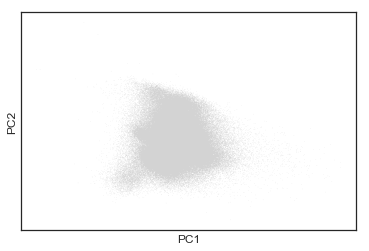

In [72]:
# Calculate PCA
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)

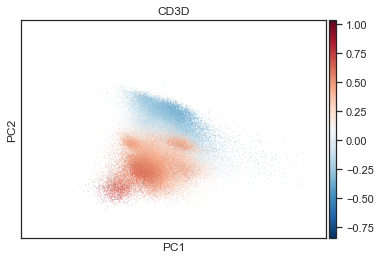

In [73]:
sc.pl.pca(adata, color='CD3D', color_map="RdBu_r")

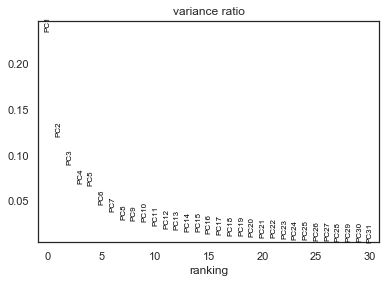

In [74]:
sc.pl.pca_variance_ratio(adata)

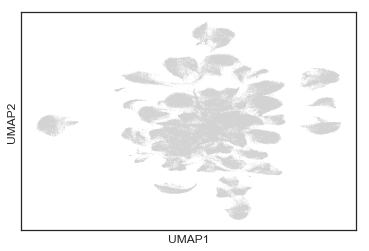

In [12]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=7)
sc.tl.umap(adata)
sc.pl.umap(adata)

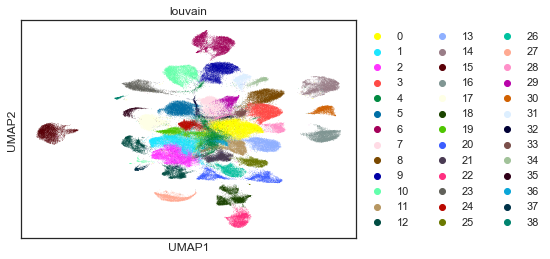

In [9]:
sc.pl.umap(adata,color='louvain')

... storing 'cores' as categorical


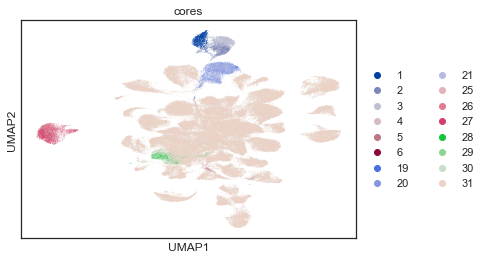

In [59]:
sc.pl.umap(adata,color='cores')

In [5]:
sc.tl.louvain(adata)

### Subset data

In [15]:
p1 = adata[adata.obs['cores'].isin(['1', '2', '3'])]
#p1 = adata[adata.obs['cores'] == s]
p1

View of AnnData object with n_obs × n_vars = 6624 × 35 
    obs: 'cores', 'louvain'
    uns: 'louvain', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

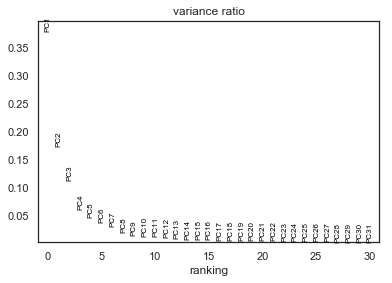

In [16]:
# Calculate PCA
sc.tl.pca(p1, svd_solver='arpack')
sc.pl.pca_variance_ratio(p1)

In [17]:
# UMAP
sc.pp.neighbors(p1, n_neighbors=5, n_pcs=8)
sc.tl.umap(p1)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


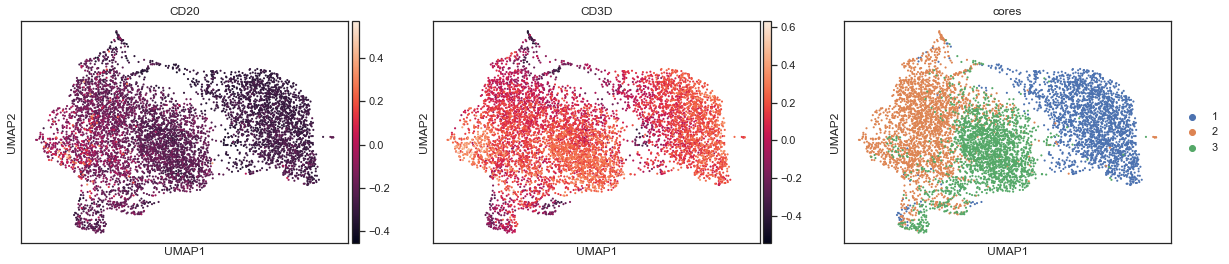

In [33]:
sc.pl.umap(p1, color=['CD20', 'CD3D', 'cores'])

### Batch correction

In [76]:
s1 = adata[adata.obs['cores'].isin(['1'])]
s2 = adata[adata.obs['cores'].isin(['2'])]
s3 = adata[adata.obs['cores'].isin(['3'])]
s4 = adata[adata.obs['cores'].isin(['4'])]
s5 = adata[adata.obs['cores'].isin(['5'])]
s6 = adata[adata.obs['cores'].isin(['6'])]

In [77]:
c = sce.pp.mnn_correct(s1,s2,s3,s4,s5,s6, batch_key='cores')

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 5: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 2 of 5: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 3 of 5: processing batch 3
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 4 of 5: processing batch 4
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 5 of 5: processing batch 5
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


In [78]:
p2 = c[0]

In [79]:
# UMAP
sc.pp.neighbors(p2, n_neighbors=30, n_pcs=8)
sc.tl.umap(p2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

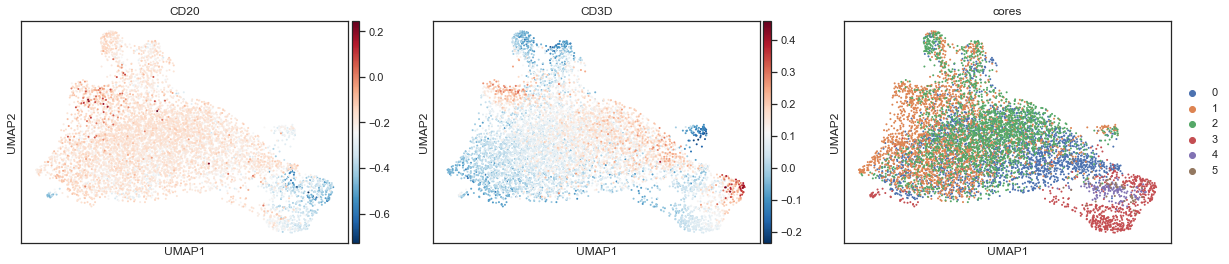

In [80]:
sc.pl.umap(p2, color=['CD20', 'CD3D', 'cores'], color_map="RdBu_r")

# 

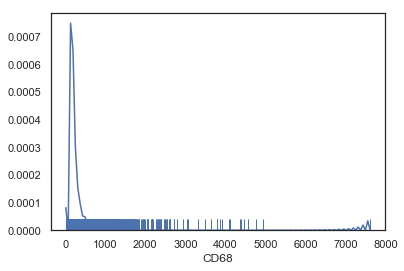

In [44]:
sns.distplot(data['CD68'], hist=False, rug=True)

#### Normalize based on custom methiod

In [45]:
file_url = 'https://raw.githubusercontent.com/ajitjohnson/Jupyter-Notebooks/master/py_scripts/mi_pp_normalize.py'
exec(open(wget.download(file_url)).read())
data_nn = mi_pp_normalize (data)

Applying log transformation and quantile normalization...


In [47]:
# Drop DAPI
data_nn = data_nn.drop(list(data_nn.filter(regex='DAPI|BACK', axis=1)), axis=1)

,CD2,TCR,CD4,CD3D,CD7,CD43,ALK,CD45,CD10,KI67,...,CD21,S6P,ERK,TBET,TDT,BCL6,EBVLMP,CD31,CD16,PSTAT3
ID,,,,,,,,,,,,,,,,,,,,,
1_1,-0.406640,0.231810,-0.61038,-0.245100,-0.39460,-0.35536,-0.410740,-0.058780,-0.990550,-0.075095,...,-0.39021,-0.54668,-0.54125,0.068790,-0.94468,-0.88867,-0.365380,-0.37063,-0.517090,-0.27502
1_2,-0.208120,0.353310,-0.40702,-0.143160,-0.32192,-0.40222,-0.457840,-0.026391,-0.548220,-0.116100,...,-0.34019,-0.43913,-0.62656,0.351130,-0.41090,-0.69078,-0.158590,-0.36016,-0.296570,-0.23356
1_3,-0.345370,0.028613,-0.46394,-0.186560,-0.37300,-0.20602,-0.524310,0.073478,-0.816200,0.071263,...,-0.38670,-0.50294,-0.68652,-0.032020,-0.66349,-0.69435,-0.355140,-0.37063,-0.376790,-0.22695
1_4,-0.120140,0.219100,-0.35657,-0.072530,-0.30623,0.01909,-0.229020,0.155930,-0.260930,-0.051495,...,-0.29164,-0.39117,-0.31303,0.150620,-0.50284,-0.58655,0.217390,-0.34998,-0.121790,-0.17680
1_5,-0.031985,-0.049000,-0.19408,-0.050959,-0.28056,-0.22607,0.057713,0.243970,-0.041982,-0.101010,...,-0.32303,-0.37833,0.12395,-0.061973,-0.20285,-0.45637,0.064211,-0.34009,0.028438,-0.12005


In [49]:
# Convert to AnnData 
adata_n = sc.AnnData(data_nn)

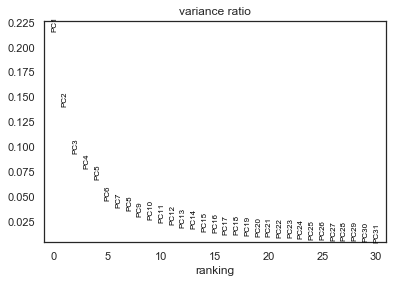

In [50]:
# Calculate PCA
sc.tl.pca(adata_n, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata_n)

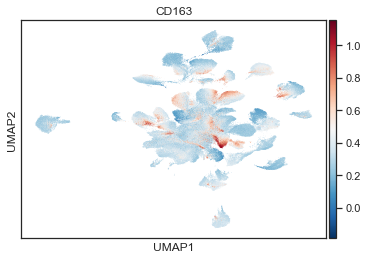

In [52]:
sc.pp.neighbors(adata_n, n_neighbors=30, n_pcs=5)
sc.tl.umap(adata_n)
sc.pl.umap(adata_n, color='CD163', color_map="RdBu_r")

In [ ]:
sc.tl.draw_graph(pdata)
sc.pl.draw_graph(pdata)

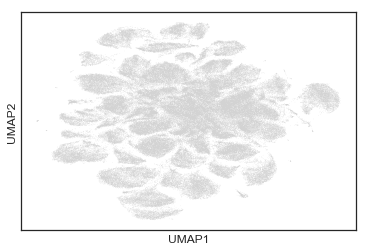

In [57]:
sc.pp.neighbors(adata, n_neighbors=5, n_pcs=7)
sc.tl.umap(adata)
sc.pl.umap(adata)

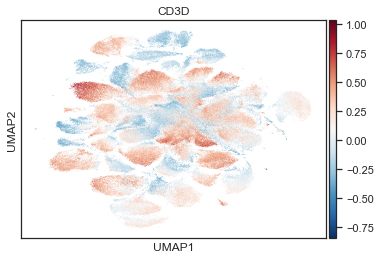

In [58]:
sc.pl.umap(adata,color='CD3D', color_map="RdBu_r")